In [1]:
#   CELL 1: PREPROCESSING & FEATURE ENGINEERING
import pandas as pd
import numpy as np
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

print("LOADING & CLEANING DATA...")

# Load Dataset
try:
    df = pd.read_csv('/kaggle/input/multi-label-software-defect-prediction-dataset/dataset(1).csv')
    print(f"Data Loaded Successfully. Shape: {df.shape}")
except FileNotFoundError:
    print("ERROR: Please upload 'dataset.csv' to your notebook!")

#HANDLE MISSING VALUES ---
missing_count = df['report'].isnull().sum()
print(f"Missing values found in 'report': {missing_count}")
if missing_count > 0:
    df.dropna(subset=['report'], inplace=True)
    print(f"Dropped missing values. New Shape: {df.shape}")

# Clean Text Function
def clean_text(text):
    text = str(text).lower()                 # Lowercase
    text = re.sub(r'[^a-z\s]', '', text)     # Remove punctuation/numbers
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
    return text

# Apply cleaning
df['clean_report'] = df['report'].apply(clean_text)

# Define Multi-Label Targets
all_possible_labels = ['type_blocker', 'type_regression', 'type_bug', 
                       'type_documentation', 'type_enhancement', 
                       'type_task', 'type_dependency_upgrade']

# ANALYZE LABEL DISTRIBUTION ---
# We check how many times each label appears.
# We also drop columns that are empty (Severe Class Imbalance Fix)
valid_cols = []
for col in all_possible_labels:
    if col in df.columns:
        if df[col].sum() > 1: # Must have at least 2 positive samples
            valid_cols.append(col)
        else:
            print(f"⚠️ Dropping '{col}' because it has almost no data (Severe Imbalance).")

y = df[valid_cols].values
X_text = df['clean_report'].values

print("\nLabel Distribution (Analysis):")
print(df[valid_cols].sum().sort_values(ascending=False))

# FEATURE SELECTION & SCALING ---
print("\n>>> STEP 2: TF-IDF VECTORIZATION...")

# Feature Selection: 'max_features=5000' selects only the top 5k important words.
# Scaling: TfidfVectorizer automatically normalizes (scales) values between 0 and 1.
vectorizer = TfidfVectorizer(max_features=5000) 
X = vectorizer.fit_transform(X_text).toarray()

# Save vectorizer and column names
joblib.dump(vectorizer, 'text_vectorizer.pkl')
joblib.dump(valid_cols, 'text_label_columns.pkl')

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training Samples: {X_train.shape[0]}")
print(f"Testing Samples: {X_test.shape[0]}")

LOADING & CLEANING DATA...
Data Loaded Successfully. Shape: (1386, 8)
Missing values found in 'report': 0
⚠️ Dropping 'type_task' because it has almost no data (Severe Imbalance).

Label Distribution (Analysis):
type_documentation         1134
type_bug                    676
type_enhancement            676
type_blocker                134
type_regression             115
type_dependency_upgrade      43
dtype: int64

>>> STEP 2: TF-IDF VECTORIZATION...
Training Samples: 1108
Testing Samples: 278


In [2]:
# MODELS (MULTI-LABEL)
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neural_network import MLPClassifier


# Support Vector Machine (SVM)
# Multi-Label via One-vs-Rest (MultiOutputClassifier)
svm_model = MultiOutputClassifier(
    SVC(kernel='linear', probability=True, random_state=42)
)

# Logistic Regression
# One-vs-Rest
lr_model = MultiOutputClassifier(
    LogisticRegression(max_iter=1000, random_state=42)
)

# Deep Neural Network (DNN)
# Sigmoid Output Layer (handled automatically by sklearn for multi-label)
dnn_model = MLPClassifier(
    hidden_layer_sizes=(128, 64), # 2 Hidden Layers
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42
)

# Perceptron (For Online Learning)
# We wrap it but will train it differently in the next cell
perc_model = MultiOutputClassifier(
    Perceptron(eta0=0.1, random_state=42)
)

print("Cell 2 Executed")

Cell 2 Executed


In [3]:
# TRAINING (BATCH & ONLINE)
print("TRAINING...")

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training Set: {X_train.shape[0]} samples")
print(f"Test Set: {X_test.shape[0]} samples")

# Train Batch Models (SVM, LR, DNN)
print("\nTraining SVM...")
svm_model.fit(X_train, y_train)
joblib.dump(svm_model, 'text_model_svm.pkl')

print("Training Logistic Regression...")
lr_model.fit(X_train, y_train)
joblib.dump(lr_model, 'text_model_logistic.pkl')

print("Training DNN...")
dnn_model.fit(X_train, y_train)
joblib.dump(dnn_model, 'text_model_dnn.pkl')

# Perceptron Online Learning (Sample-by-Sample)
print("Training Perceptron (Online Mode)...")

# We must tell the model how many classes exist first
# We pass the first batch just to initialize the structure
classes_list = [np.array([0, 1]) for _ in range(y.shape[1])]
perc_model.partial_fit(X_train[0:1], y_train[0:1], classes=classes_list)

# Update weights after EACH sample
for i in range(1, len(X_train)):
    # Reshape(1, -1) makes it a single sample row
    perc_model.partial_fit(X_train[i].reshape(1, -1), y_train[i].reshape(1, -1))
    
    if i % 200 == 0:
        print(f"  Processed {i} samples...")

joblib.dump(perc_model, 'text_model_perceptron.pkl')
print("All models trained and saved!")

TRAINING...
Training Set: 1108 samples
Test Set: 278 samples

Training SVM...
Training Logistic Regression...
Training DNN...
Training Perceptron (Online Mode)...
  Processed 200 samples...
  Processed 400 samples...
  Processed 600 samples...
  Processed 800 samples...
  Processed 1000 samples...
All models trained and saved!


In [4]:
# EVALUATION METRICS
from sklearn.metrics import hamming_loss, f1_score

print("EVALUATION...")

# Helper Function for Precision@K
def precision_at_k(y_true, y_pred_prob, k=3):
    # argsort gives indices of sorted values, we take last k (highest prob)
    top_k_indices = np.argsort(y_pred_prob, axis=1)[:, -k:]
    
    scores = []
    for i in range(len(y_true)):
        # Find which labels are actually True (1)
        true_indices = np.where(y_true[i] == 1)[0]
        
        # Counts how many of our Top K guesses are in the True list
        relevant = np.intersect1d(top_k_indices[i], true_indices)
        
        # Calculate precision for this sample
        if k > 0:
            scores.append(len(relevant) / k)
        else:
            scores.append(0)
            
    return np.mean(scores)

models = {
    "SVM": svm_model,
    "Logistic Regression": lr_model,
    "Perceptron (Online)": perc_model,
    "DNN": dnn_model
}

results = []

for name, model in models.items():
    # Get Predictions (0 or 1)
    y_pred = model.predict(X_test)
    
    # Get Probabilities (Confidence) for Precision@K
    try:
        if hasattr(model, "predict_proba"):
            # MultiOutput returns a list of arrays (one per label)
            # We stack them to get a shape of (n_samples, n_labels)
            probas_list = model.predict_proba(X_test)
            # Extract the probability of class '1' for each label
            y_prob = np.array([p[:, 1] for p in probas_list]).T
        else:
            # Perceptron doesn't have predict_proba, using simple predictions
            y_prob = y_pred
    except:
        y_prob = y_pred

    # Calculate Metrics
    hm_loss = hamming_loss(y_test, y_pred)
    micro_f1 = f1_score(y_test, y_pred, average='micro')
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    p3 = precision_at_k(y_test, y_prob, k=3)
    p5 = precision_at_k(y_test, y_prob, k=5)
    
    results.append({
        "Model": name,
        "Hamming Loss": round(hm_loss, 4),
        "Micro F1": round(micro_f1, 4),
        "Macro F1": round(macro_f1, 4),
        "Precision@3": round(p3, 4),
        "Precision@5": round(p5, 4)
    })

# Display Results
df_results = pd.DataFrame(results).set_index("Model")
print("\n" + "="*50)
print("FINAL RESULTS TABLE")
print("="*50)
print(df_results)

# Save to CSV
df_results.to_csv("Software_Defect_Metrics.csv")
print("\nSaved Results to 'Software_Defect_Metrics.csv'")

EVALUATION...

FINAL RESULTS TABLE
                     Hamming Loss  Micro F1  Macro F1  Precision@3  \
Model                                                                
SVM                        0.1145    0.8256    0.6063       0.6379   
Logistic Regression        0.1241    0.8085    0.4428       0.6211   
Perceptron (Online)        0.1829    0.7391    0.5270       0.6031   
DNN                        0.1181    0.8181    0.6137       0.5947   

                     Precision@5  
Model                             
SVM                       0.3986  
Logistic Regression       0.3971  
Perceptron (Online)       0.3799  
DNN                       0.3892  

Saved Results to 'Software_Defect_Metrics.csv'


GENERATING GRAPHS...
Results loaded successfully.


<Figure size 1200x700 with 0 Axes>

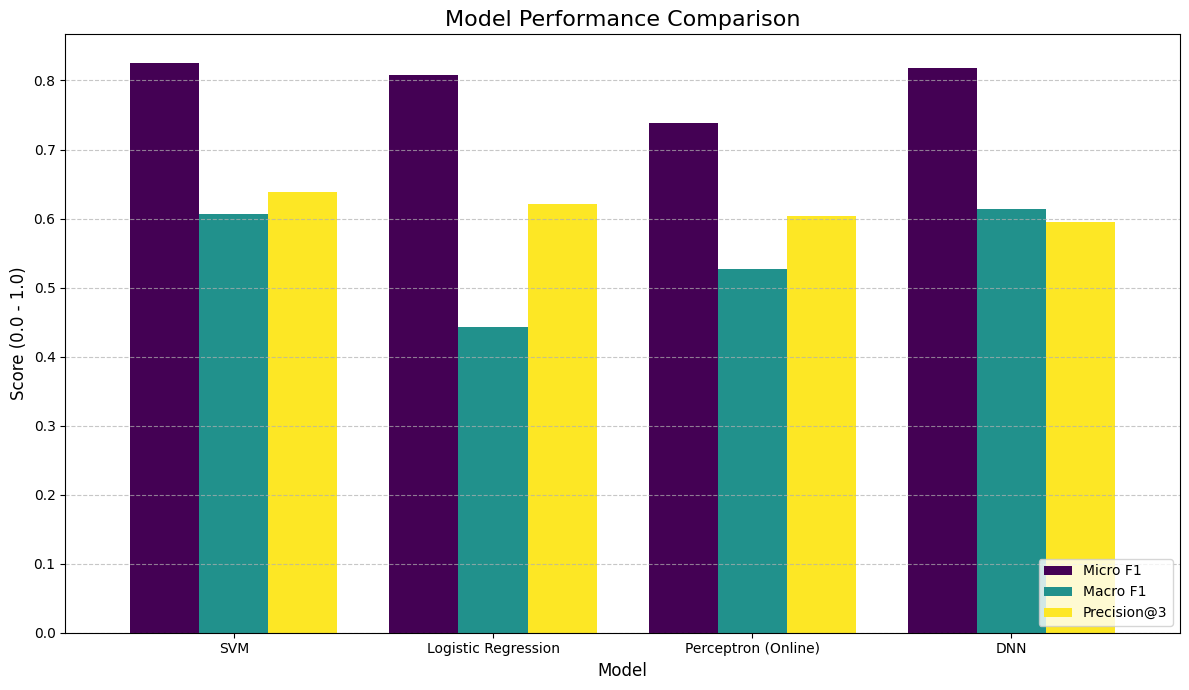


✅ Graph Saved: 'Model_Comparison.png'


In [5]:
#   CELL 5: VISUALIZATION
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("GENERATING GRAPHS...")

# Load the Results
try:
    df_results = pd.read_csv("Software_Defect_Metrics.csv", index_col="Model")
    print("Results loaded successfully.")
except FileNotFoundError:
    print("Error: Could not find 'Software_Defect_Metrics.csv'")

# 2. Create the Comparison Plot
# ploting Micro F1, Macro F1, and Precision@3 (Higher is Better)
metrics_to_plot = ['Micro F1', 'Macro F1', 'Precision@3']

plt.figure(figsize=(12, 7))
df_results[metrics_to_plot].plot(kind='bar', width=0.8, figsize=(12, 7), colormap='viridis')

plt.title('Model Performance Comparison', fontsize=16)
plt.ylabel('Score (0.0 - 1.0)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 3. Saving the Image
plt.tight_layout()
plt.savefig("Model_Comparison.png", dpi=300)
plt.show()

print("\n✅ Graph Saved: 'Model_Comparison.png'")